In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Subset, Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd

plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
def get_target_label_idx(labels, targets, shots=5, test=False):
    """
    Get the indices of labels that are included in targets.
    :param labels: array of labels
    :param targets: list/tuple of target labels
    :return: list with indices of target labels
    """
    final_list = []
    
    for t in targets:
        if test:
            final_list += np.argwhere(np.isin(labels, t)).flatten().tolist()
        else:
            final_list += np.argwhere(np.isin(labels, t)).flatten().tolist()[:shots]
    
    return final_list

In [3]:
# function to convert labels [5,6,7,8,9] to [0,1,2,3,4]
def convert_label(x):

    if x >= 5:
        return x-5
    else:
        return x

In [4]:
from torch.utils.data import Subset
from PIL import Image
from torchvision.datasets import MNIST

import torchvision.transforms as transforms

class MNIST_Dataset(Dataset):

    def __init__(self, root: str, normal_class=[5,6,7,8,9], shots=5):
        super().__init__()

        self.root = root
        self.n_classes = 2  # 0: normal, 1: outlier
        self.normal_classes = tuple(normal_class)
        self.outlier_classes = list(range(0, 10))
        self.outlier_classes = [item for item in self.outlier_classes if item not in self.normal_classes]
#         self.outlier_classes.remove(normal_class)
        print("classes: ", self.normal_classes)
#         # MNIST preprocessing: GCN (with L1 norm) and min-max feature scaling to [0,1]
        transform = transforms.Compose([transforms.ToTensor()])

#         target_transform = transforms.Lambda(lambda x: int(x in self.normal_classes))
        
        target_transform = transforms.Lambda(lambda x: convert_label(x))
        train_set = MyMNIST(root=self.root, train=True, download=True,
                            transform=transform, target_transform=target_transform)
        # Subset train_set to normal class
        train_idx_normal = get_target_label_idx(train_set.train_labels.clone().data.cpu().numpy(), self.normal_classes, shots=shots)
        self.train_set = Subset(train_set, train_idx_normal)

        test_set = MyMNIST(root=self.root, train=False, download=True,
                                transform=transform, target_transform=target_transform)
        
        test_idx_normal = get_target_label_idx(test_set.test_labels.clone().data.cpu().numpy(), self.normal_classes, test=True)
        self.test_set = Subset(test_set, test_idx_normal)

    

        
        

class MyMNIST(MNIST):
    """Torchvision MNIST class with patch of __getitem__ method to also return the index of a data sample."""

    def __init__(self, *args, **kwargs):
        super(MyMNIST, self).__init__(*args, **kwargs)

    def __getitem__(self, index):
        """Override the original method of the MNIST class.
        Args:
            index (int): Index
        Returns:
            triple: (image, target, index) where target is index of the target class.
        """
        if self.train:
            img, target = self.train_data[index], self.train_labels[index]
        else:
            img, target = self.test_data[index], self.test_labels[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img.numpy(), mode='L')

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target, index  # only line changed



In [5]:
""" LeNet architecture implementation
"""
from torch import nn, optim
from torch.autograd import Variable
import torch.nn.functional as F

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, (5,5), padding=2)
        self.conv2 = nn.Conv2d(6, 16, (5,5))
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 5)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            
            if phase == 'train':
                model.train()  # Set model to training mode
                
                running_loss = 0.0
                running_corrects = 0
                
                for data in train_loader:
                    inputs, labels, idx = data
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    
                    
                    optimizer.zero_grad()
                    with torch.set_grad_enabled(True):
                        outputs = model(inputs)
                        
                        _, preds = torch.max(outputs, 1)
#                         print(preds, labels)
                        loss = criterion(outputs, labels)
                        
                        loss.backward()
                        optimizer.step()
                    
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    
                scheduler.step()
                
                epoch_loss = running_loss / train_size
                epoch_acc = running_corrects.double() / train_size

                print('{} Loss: {:.4f} Acc: {:.4f}'.format('Train', epoch_loss, epoch_acc))
                    
            else:
                
                model.eval()   # Set model to evaluate mode
                
                running_loss = 0.0
                running_corrects = 0
                
                for data in test_loader:
                    inputs, labels, idx = data
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    optimizer.zero_grad()
                    with torch.set_grad_enabled(False):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        
                        loss = criterion(outputs, labels)
                
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                
                epoch_loss = running_loss / test_size
                epoch_acc = running_corrects.double() / test_size
                
                print('{} Loss: {:.4f} Acc: {:.4f}'.format('Val', epoch_loss, epoch_acc))
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())


        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_acc

classes:  (5, 6, 7, 8, 9)
Labels:  tensor([4, 1, 4, 3, 0])


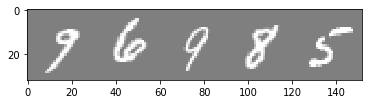

In [8]:
mninst_dataset = MNIST_Dataset(root='data/', shots=5)
train_loader = DataLoader(mninst_dataset.train_set, batch_size=5, shuffle=True, num_workers=0)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels, idx = dataiter.next()
print("Labels: ", labels)

# show images
imshow(torchvision.utils.make_grid(images))
    

# Section 2: Training Models

# 2.1 Plain LeNet Model

In [9]:
shot_list = [5, 10, 15, 20, 25, 30] # no of images per class 
n_epochs = 20
best_net_dict = {}
best_acc_list = []
for shot in shot_list:
    
    mninst_dataset = MNIST_Dataset(root='data/', normal_class=[0,1,2,3,4], shots=shot)
    train_loader = DataLoader(mninst_dataset.train_set, batch_size=5, shuffle=True, num_workers=0)
    test_loader = DataLoader(mninst_dataset.test_set, batch_size=200, shuffle=True, num_workers=0)
    train_size =  len(mninst_dataset.train_set)
    test_size = len(mninst_dataset.test_set)
    
    net = LeNet().to(device)
# loading pretrained model
#     net = torch.load('LeNet_5_class_pretrained_model.tar')
    criterion = nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    optimizer_ft = optim.Adam(net.parameters(), lr=0.001)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

    best_net, best_acc = train_model(net, criterion, optimizer_ft, exp_lr_scheduler,
                           num_epochs=n_epochs)
    
    best_acc_list.append(best_acc.item())
    best_net_dict.update({shot : best_net})

classes:  (0, 1, 2, 3, 4)
Epoch 0/19
----------


D:\Installation\anaconda\envs\dl_env\lib\site-packages\torchvision\datasets\mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
D:\Installation\anaconda\envs\dl_env\lib\site-packages\torchvision\datasets\mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
D:\Installation\anaconda\envs\dl_env\lib\site-packages\torchvision\datasets\mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
D:\Installation\anaconda\envs\dl_env\lib\site-packages\torchvision\datasets\mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


Train Loss: 1.6157 Acc: 0.2000
Val Loss: 1.6018 Acc: 0.2008

Epoch 1/19
----------
Train Loss: 1.5959 Acc: 0.2000
Val Loss: 1.5874 Acc: 0.2008

Epoch 2/19
----------
Train Loss: 1.5751 Acc: 0.2000
Val Loss: 1.5630 Acc: 0.2168

Epoch 3/19
----------
Train Loss: 1.5356 Acc: 0.5200
Val Loss: 1.5171 Acc: 0.5795

Epoch 4/19
----------
Train Loss: 1.4701 Acc: 0.7200
Val Loss: 1.4281 Acc: 0.5884

Epoch 5/19
----------
Train Loss: 1.3680 Acc: 0.5200
Val Loss: 1.2896 Acc: 0.6394

Epoch 6/19
----------
Train Loss: 1.1808 Acc: 0.7200
Val Loss: 1.0976 Acc: 0.8327

Epoch 7/19
----------
Train Loss: 1.0220 Acc: 0.9600
Val Loss: 1.0750 Acc: 0.8449

Epoch 8/19
----------
Train Loss: 0.9927 Acc: 0.9600
Val Loss: 1.0450 Acc: 0.8482

Epoch 9/19
----------
Train Loss: 0.9556 Acc: 0.9600
Val Loss: 1.0181 Acc: 0.8467

Epoch 10/19
----------
Train Loss: 0.9293 Acc: 0.9200
Val Loss: 0.9919 Acc: 0.8397

Epoch 11/19
----------
Train Loss: 0.8980 Acc: 0.9200
Val Loss: 0.9675 Acc: 0.8303

Epoch 12/19
----------
T

Train Loss: 0.0181 Acc: 1.0000
Val Loss: 0.1816 Acc: 0.9453

Epoch 16/19
----------
Train Loss: 0.0180 Acc: 1.0000
Val Loss: 0.1819 Acc: 0.9457

Epoch 17/19
----------
Train Loss: 0.0179 Acc: 1.0000
Val Loss: 0.1816 Acc: 0.9455

Epoch 18/19
----------
Train Loss: 0.0178 Acc: 1.0000
Val Loss: 0.1811 Acc: 0.9457

Epoch 19/19
----------
Train Loss: 0.0177 Acc: 1.0000
Val Loss: 0.1815 Acc: 0.9455

Training complete in 0m 29s
Best val Acc: 0.947266
classes:  (0, 1, 2, 3, 4)
Epoch 0/19
----------
Train Loss: 1.5997 Acc: 0.3200
Val Loss: 1.5414 Acc: 0.5120

Epoch 1/19
----------
Train Loss: 1.2906 Acc: 0.6467
Val Loss: 0.8579 Acc: 0.8311

Epoch 2/19
----------
Train Loss: 0.4900 Acc: 0.8600
Val Loss: 0.3802 Acc: 0.8461

Epoch 3/19
----------
Train Loss: 0.2378 Acc: 0.9400
Val Loss: 0.3833 Acc: 0.8698

Epoch 4/19
----------
Train Loss: 0.1769 Acc: 0.9467
Val Loss: 0.3962 Acc: 0.8511

Epoch 5/19
----------
Train Loss: 0.1446 Acc: 0.9600
Val Loss: 0.1552 Acc: 0.9525

Epoch 6/19
----------
Train 

# Summary: Accuracy on Plain LeNet Model

In [11]:
# print("Pretrained model Acc: 0.916067")
print("5 way N shots classification accuracy using LeNet")
best_acc_df = pd.DataFrame({'# images per class' : shot_list,
                            'Accuracy' : best_acc_list})
best_acc_df

5 way N shots classification accuracy using LeNet


,# images per class,Accuracy
0,5,0.858144
1,10,0.893559
2,15,0.908737
3,20,0.934034
4,25,0.947266
5,30,0.960887


# 2.2 Using Pretrained Model

Pretraining LeNet using (5,6,7,8,9) classes images and use them to predict for (0,1,2,3,4) classes in different shots

# Pretraining Model

In [13]:
# pretraining model
mninst_dataset = MNIST_Dataset(root='data/', normal_class=[5,6,7,8,9] ,shots=1000)
train_loader = DataLoader(mninst_dataset.train_set, batch_size=64, shuffle=True, num_workers=0)
test_loader = DataLoader(mninst_dataset.test_set, batch_size=200, shuffle=True, num_workers=0)
train_size =  len(mninst_dataset.train_set)
test_size = len(mninst_dataset.test_set)

net = LeNet().to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(net.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 15 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=15, gamma=0.1)

best_net, best_acc = train_model(net, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=100)

classes:  (5, 6, 7, 8, 9)
Epoch 0/99
----------


D:\Installation\anaconda\envs\dl_env\lib\site-packages\torchvision\datasets\mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
D:\Installation\anaconda\envs\dl_env\lib\site-packages\torchvision\datasets\mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
D:\Installation\anaconda\envs\dl_env\lib\site-packages\torchvision\datasets\mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


Train Loss: 0.7154 Acc: 0.7608


D:\Installation\anaconda\envs\dl_env\lib\site-packages\torchvision\datasets\mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


Val Loss: 0.3060 Acc: 0.8978

Epoch 1/99
----------
Train Loss: 0.2198 Acc: 0.9252
Val Loss: 0.1681 Acc: 0.9473

Epoch 2/99
----------
Train Loss: 0.1376 Acc: 0.9562
Val Loss: 0.1619 Acc: 0.9484

Epoch 3/99
----------
Train Loss: 0.1074 Acc: 0.9658
Val Loss: 0.1162 Acc: 0.9605

Epoch 4/99
----------
Train Loss: 0.0789 Acc: 0.9740
Val Loss: 0.0877 Acc: 0.9724

Epoch 5/99
----------
Train Loss: 0.0666 Acc: 0.9772
Val Loss: 0.0783 Acc: 0.9743

Epoch 6/99
----------
Train Loss: 0.0573 Acc: 0.9792
Val Loss: 0.0928 Acc: 0.9687

Epoch 7/99
----------
Train Loss: 0.0453 Acc: 0.9854
Val Loss: 0.0660 Acc: 0.9774

Epoch 8/99
----------
Train Loss: 0.0344 Acc: 0.9894
Val Loss: 0.0614 Acc: 0.9780

Epoch 9/99
----------
Train Loss: 0.0337 Acc: 0.9894
Val Loss: 0.0593 Acc: 0.9790

Epoch 10/99
----------
Train Loss: 0.0325 Acc: 0.9878
Val Loss: 0.0984 Acc: 0.9673

Epoch 11/99
----------
Train Loss: 0.0291 Acc: 0.9904
Val Loss: 0.0476 Acc: 0.9846

Epoch 12/99
----------
Train Loss: 0.0169 Acc: 0.9960
V

Val Loss: 0.0403 Acc: 0.9858

Epoch 99/99
----------
Train Loss: 0.0022 Acc: 0.9998
Val Loss: 0.0403 Acc: 0.9858

Training complete in 6m 44s
Best val Acc: 0.986423


In [16]:
# Saving the pretrained model
pretrained_model_acc = best_acc.item()
torch.save(best_net, 'LeNet_5_class_pretrained_model.tar')
print("Pretrained Model Validation Accuracy: ", pretrained_model_acc)

Pretrained Model Validation Accuracy:  0.9864225468010698


D:\Installation\anaconda\envs\dl_env\lib\site-packages\torch\serialization.py:401: UserWarning: Couldn't retrieve source code for container of type LeNet. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "


# Few shot learing in Pretrained Model

In [19]:
shot_list = [5, 10, 15, 20, 25, 30] # no of images per class 
n_epochs = 20
pretrained_best_net_dict = {}
pretrained_best_acc_list = []
for shot in shot_list:
    
    mninst_dataset = MNIST_Dataset(root='data/', normal_class=[0,1,2,3,4], shots=shot)
    train_loader = DataLoader(mninst_dataset.train_set, batch_size=5, shuffle=True, num_workers=0)
    test_loader = DataLoader(mninst_dataset.test_set, batch_size=200, shuffle=True, num_workers=0)
    train_size =  len(mninst_dataset.train_set)
    test_size = len(mninst_dataset.test_set)
    
    
# loading pretrained model
    net = torch.load('LeNet_5_class_pretrained_model.tar')
    criterion = nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    optimizer_ft = optim.Adam(net.parameters(), lr=0.001)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

    best_net, best_acc = train_model(net, criterion, optimizer_ft, exp_lr_scheduler,
                           num_epochs=n_epochs)
    
    pretrained_best_acc_list.append(best_acc.item())
    pretrained_best_net_dict.update({shot : best_net})

classes:  (0, 1, 2, 3, 4)
Epoch 0/19
----------
Train Loss: 5.0858 Acc: 0.3600


D:\Installation\anaconda\envs\dl_env\lib\site-packages\torchvision\datasets\mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
D:\Installation\anaconda\envs\dl_env\lib\site-packages\torchvision\datasets\mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
D:\Installation\anaconda\envs\dl_env\lib\site-packages\torchvision\datasets\mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
D:\Installation\anaconda\envs\dl_env\lib\site-packages\torchvision\datasets\mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


Val Loss: 2.9969 Acc: 0.4555

Epoch 1/19
----------
Train Loss: 2.0011 Acc: 0.4800
Val Loss: 1.4790 Acc: 0.6052

Epoch 2/19
----------
Train Loss: 0.5536 Acc: 0.7600
Val Loss: 0.9772 Acc: 0.7124

Epoch 3/19
----------
Train Loss: 0.1865 Acc: 0.9600
Val Loss: 0.7707 Acc: 0.7788

Epoch 4/19
----------
Train Loss: 0.0626 Acc: 1.0000
Val Loss: 0.6982 Acc: 0.8035

Epoch 5/19
----------
Train Loss: 0.0411 Acc: 1.0000
Val Loss: 0.6802 Acc: 0.8109

Epoch 6/19
----------
Train Loss: 0.0303 Acc: 1.0000
Val Loss: 0.6788 Acc: 0.8157

Epoch 7/19
----------
Train Loss: 0.0271 Acc: 1.0000
Val Loss: 0.6781 Acc: 0.8161

Epoch 8/19
----------
Train Loss: 0.0264 Acc: 1.0000
Val Loss: 0.6767 Acc: 0.8167

Epoch 9/19
----------
Train Loss: 0.0256 Acc: 1.0000
Val Loss: 0.6746 Acc: 0.8171

Epoch 10/19
----------
Train Loss: 0.0248 Acc: 1.0000
Val Loss: 0.6722 Acc: 0.8175

Epoch 11/19
----------
Train Loss: 0.0239 Acc: 1.0000
Val Loss: 0.6696 Acc: 0.8181

Epoch 12/19
----------
Train Loss: 0.0232 Acc: 1.0000
V

Train Loss: 0.0070 Acc: 1.0000
Val Loss: 0.2317 Acc: 0.9333

Epoch 16/19
----------
Train Loss: 0.0070 Acc: 1.0000
Val Loss: 0.2317 Acc: 0.9335

Epoch 17/19
----------
Train Loss: 0.0069 Acc: 1.0000
Val Loss: 0.2317 Acc: 0.9333

Epoch 18/19
----------
Train Loss: 0.0069 Acc: 1.0000
Val Loss: 0.2317 Acc: 0.9333

Epoch 19/19
----------
Train Loss: 0.0069 Acc: 1.0000
Val Loss: 0.2319 Acc: 0.9333

Training complete in 0m 29s
Best val Acc: 0.933645
classes:  (0, 1, 2, 3, 4)
Epoch 0/19
----------
Train Loss: 1.7171 Acc: 0.6600
Val Loss: 0.5344 Acc: 0.8408

Epoch 1/19
----------
Train Loss: 0.2611 Acc: 0.9267
Val Loss: 0.3188 Acc: 0.8932

Epoch 2/19
----------
Train Loss: 0.1266 Acc: 0.9600
Val Loss: 0.2820 Acc: 0.9115

Epoch 3/19
----------
Train Loss: 0.0743 Acc: 0.9733
Val Loss: 0.2345 Acc: 0.9290

Epoch 4/19
----------
Train Loss: 0.0262 Acc: 0.9933
Val Loss: 0.2454 Acc: 0.9292

Epoch 5/19
----------
Train Loss: 0.0169 Acc: 1.0000
Val Loss: 0.2284 Acc: 0.9350

Epoch 6/19
----------
Train 

5 class LeNet model is trained for [5,6,7,8,9] classes and accuracy acheived 0.9864, this model is taken as pretrained model.

Pretrained model is trained using differente shots [5 -30] for classes [0,1,2,3,4] for 20 epochs and following results acheived

# Summary: Accuracy on Pretrained Model

In [22]:
print("Pretrained model Acc: ", pretrained_model_acc)
print("5 way N shots classification accuracy using LeNet")
pretrained_best_acc_df = pd.DataFrame({'# images per class' : shot_list,
                            'Accuracy' : pretrained_best_acc_list})
pretrained_best_acc_df

Pretrained model Acc:  0.9864225468010698
5 way N shots classification accuracy using LeNet


,# images per class,Accuracy
0,5,0.819809
1,10,0.909710
2,15,0.916521
3,20,0.927418
4,25,0.933645
5,30,0.935007
